# Importing Packages and Data

In [65]:
%matplotlib inline
import seaborn as sns
sns.set_style("white")
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [66]:
%matplotlib inline 
from sklearn.cross_validation import cross_val_score, ShuffleSplit, train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn import linear_model
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import os


In [67]:
lebron = pd.read_csv('datasets/nba/Lebron.csv', delimiter = ',')


# Cleaning Data

There are NA's in the data so I got rid of them.

In [68]:
nan=float('nan')
lebron=lebron[~np.isnan(lebron['SHOT_CLOCK'])]

nan=float('nan')
lebron=lebron[~np.isnan(lebron['FGM'])]

In [176]:
lebron_df = pd.DataFrame(lebron)
lebron_df.columns

Index(['GAME_ID', 'MATCHUP', 'LOCATION', 'WIN/LOSS', 'FINAL_MARGIN',
       'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES',
       'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT',
       'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST',
       'FGM', 'PTS', 'player_name', 'player_id'],
      dtype='object')

# Assigning Features and Target

I assigned my features to 'x' and my target to 'y.'

In [315]:
x = lebron_df [["SHOT_DIST", "TOUCH_TIME", "CLOSE_DEF_DIST", "SHOT_CLOCK"]]
x[0:4]

,SHOT_DIST,TOUCH_TIME,CLOSE_DEF_DIST,SHOT_CLOCK
0,7.0,9.5,0.8,13.7
1,5.4,7.9,2.5,15.2
2,23.2,5.6,3.5,12.3
4,3.1,2.7,3.5,20.8


In [316]:
y = lebron_df["FGM"]
y[0:4]

0    0
1    0
2    1
4    1
Name: FGM, dtype: int64

# Rejoin x and y 

In [317]:
xy = x.copy() 
xy['Target-FGM'] = y


In [318]:
xy.head(5)

,SHOT_DIST,TOUCH_TIME,CLOSE_DEF_DIST,SHOT_CLOCK,Target-FGM
0,7.0,9.5,0.8,13.7,0
1,5.4,7.9,2.5,15.2,0
2,23.2,5.6,3.5,12.3,1
4,3.1,2.7,3.5,20.8,1
5,5.7,8.3,0.2,16.2,0


# Correlation off Features to target

In [319]:
xy.corr(method="pearson")

,SHOT_DIST,TOUCH_TIME,CLOSE_DEF_DIST,SHOT_CLOCK,Target-FGM
SHOT_DIST,1.000000,-0.021199,0.254135,-0.309658,-0.271434
TOUCH_TIME,-0.021199,1.000000,-0.135541,-0.397006,-0.120932
CLOSE_DEF_DIST,0.254135,-0.135541,1.000000,0.137943,0.042382
SHOT_CLOCK,-0.309658,-0.397006,0.137943,1.000000,0.173656
Target-FGM,-0.271434,-0.120932,0.042382,0.173656,1.000000


# Gaussian Naive Bayes

In [320]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix 
gnb = GaussianNB()
shot_model = gnb.fit(x,y)
pred_y = shot_model.predict(x)
print("Number of missed shots out of total %d points: %d" % ( x["SHOT_DIST"].count(), (y != pred_y  ).sum()))

confusion_matrix(y, pred_y)

pd.crosstab(y, pred_y, rownames=['True'], colnames=['Predicted'], margins=True)

Number of missed shots out of total 947 points: 361


Predicted,0,1,All
True,,,
0,350,129,479
1,232,236,468
All,582,365,947


# Model Accuracy 

Adding up the true positives(1,1) and the true negatives(0,0) and dividing by the total I can get my model acuracy for Naive Bayes.

In [322]:
model_accuracy = (350+236)/974
model_accuracy

0.6016427104722792

# More Testsing

In [171]:
n_shots_taken = lebron_df["FGM"].count()
print(n_shots_taken)

947


In [172]:
n_shots_made = lebron_df["FGM"].sum()
print(n_shots_made)

468


In [162]:
fg_percentage = n_shots_made / n_shots_taken 

print("Field Goal Percentage {0: 1f}%".format(100*fg_percentage))

Field Goal Percentage  49.419219%


In [323]:
x_all = SelectKBest(f_regression, k='all').fit_transform(x, y)

In [324]:
X_train, X_test, y_train, y_test = train_test_split(x_all, y, test_size=0.30)
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)
y_train_predict = regr.predict(X_train)
y_test_predict = regr.predict(X_test)
train_score = regr.score(X_train,y_train)
pred_score = regr.score(X_test, y_test)
print("Train, Test:",train_score, pred_score)

Train, Test: 0.110564518705 0.0691145990329


In [325]:
regr = linear_model.LinearRegression()
scores = cross_val_score(regr, x_all, y, cv=ShuffleSplit(n=len(x_all), n_iter=10, test_size=.1), scoring='r2')
print("Linear Regression Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Linear Regression Accuracy: 0.08 (+/- 0.12)


In [326]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
nn3_model = KNeighborsRegressor(n_neighbors=3)
nn5_model = KNeighborsRegressor(n_neighbors=5)
nn7_model = KNeighborsRegressor(n_neighbors=7)
nn9_model = KNeighborsRegressor(n_neighbors=9)
decision_tree = tree.DecisionTreeRegressor()
poly2 = Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression(fit_intercept=False))])
poly3 = Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression(fit_intercept=False))])
poly4 = Pipeline([('poly', PolynomialFeatures(degree=4)),('linear', LinearRegression(fit_intercept=False))])
poly5 = Pipeline([('poly', PolynomialFeatures(degree=5)),('linear', LinearRegression(fit_intercept=False))])
rf = RandomForestRegressor()
models = [ {'name' : '3-Nearest Neighbors', 'estimator' : nn3_model},
          {'name' : '5-Nearest Neighbors', 'estimator' : nn5_model},
          {'name' : '7-Nearest Neighbors', 'estimator' : nn7_model},
          {'name' : '9-Nearest Neighbors', 'estimator' : nn9_model},
          {'name' : 'Decision Tree', 'estimator' : decision_tree},
          {'name' : 'Polynomial 2nd degree', 'estimator' : poly2},
          {'name' : 'Polynomial 3rd degree', 'estimator' : poly3},
          {'name' : 'Polynomial 4th degree', 'estimator' : poly4},
          {'name' : 'Polynomial 5th degree', 'estimator' : poly5},
          {'name' : 'Random Forest', 'estimator' : rf}
         ]
for model in models:
    scores = cross_val_score(model['estimator'], x_all, y, cv=10, scoring='r2' )
    print(" %s Accuracy: %0.2f (+/- %0.2f)" % (model['name'], scores.mean(), scores.std() * 2))

 3-Nearest Neighbors Accuracy: -0.17 (+/- 0.26)
 5-Nearest Neighbors Accuracy: -0.06 (+/- 0.21)
 7-Nearest Neighbors Accuracy: -0.02 (+/- 0.17)
 9-Nearest Neighbors Accuracy: 0.02 (+/- 0.15)
 Decision Tree Accuracy: -0.79 (+/- 0.37)
 Polynomial 2nd degree Accuracy: 0.08 (+/- 0.11)
 Polynomial 3rd degree Accuracy: 0.05 (+/- 0.15)
 Polynomial 4th degree Accuracy: -1.96 (+/- 9.64)
 Polynomial 5th degree Accuracy: -1133.06 (+/- 4560.61)
 Random Forest Accuracy: -0.09 (+/- 0.18)


# Descriptive Statistics

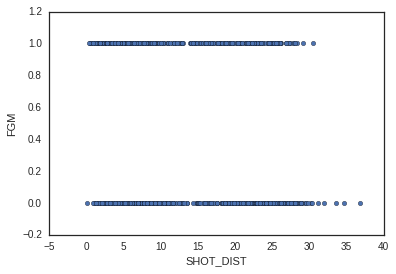

In [78]:
lebron_df.plot(kind="scatter", x= 'SHOT_DIST', y= 'FGM')


In [40]:
lebron_df.groupby("FGM").CLOSEST_DEFENDER.describe()

FGM        
0    count                 479
     unique                175
     top         Hill, Solomon
     freq                   13
1    count                 468
     unique                194
     top       Wiggins, Andrew
     freq                   12
Name: CLOSEST_DEFENDER, dtype: object

In [41]:
lebron_df.groupby("FGM").SHOT_CLOCK.describe()

FGM       
0    count    479.000000
     mean      10.784760
     std        5.969301
     min        0.200000
     25%        5.550000
     50%       10.300000
     75%       15.500000
     max       23.000000
1    count    468.000000
     mean      12.976496
     std        6.468156
     min        0.500000
     25%        7.900000
     50%       12.750000
     75%       19.000000
     max       24.000000
Name: SHOT_CLOCK, dtype: float64

In [102]:
lebron_df.groupby("FGM").DRIBBLES.describe()

FGM       
0    count    479.000000
     mean       5.052192
     std        5.640873
     min        0.000000
     25%        1.000000
     50%        3.000000
     75%        7.000000
     max       26.000000
1    count    468.000000
     mean       4.141026
     std        4.963398
     min        0.000000
     25%        0.000000
     50%        2.000000
     75%        6.000000
     max       25.000000
Name: DRIBBLES, dtype: float64

In [327]:
lebron_df.groupby("FGM").CLOSE_DEF_DIST.describe()

FGM       
0    count    479.000000
     mean       4.048017
     std        2.077230
     min        0.000000
     25%        2.750000
     50%        3.900000
     75%        5.000000
     max       12.800000
1    count    468.000000
     mean       4.331838
     std        4.274894
     min        0.000000
     25%        2.400000
     50%        3.700000
     75%        4.900000
     max       53.200000
Name: CLOSE_DEF_DIST, dtype: float64

In [328]:
lebron_df.groupby("FGM").TOUCH_TIME.describe()

FGM       
0    count    479.000000
     mean       6.229019
     std        4.950573
     min        0.000000
     25%        2.600000
     50%        5.000000
     75%        8.150000
     max       23.300000
1    count    468.000000
     mean       5.100000
     std        4.295229
     min       -4.300000
     25%        1.900000
     50%        3.900000
     75%        6.925000
     max       21.700000
Name: TOUCH_TIME, dtype: float64

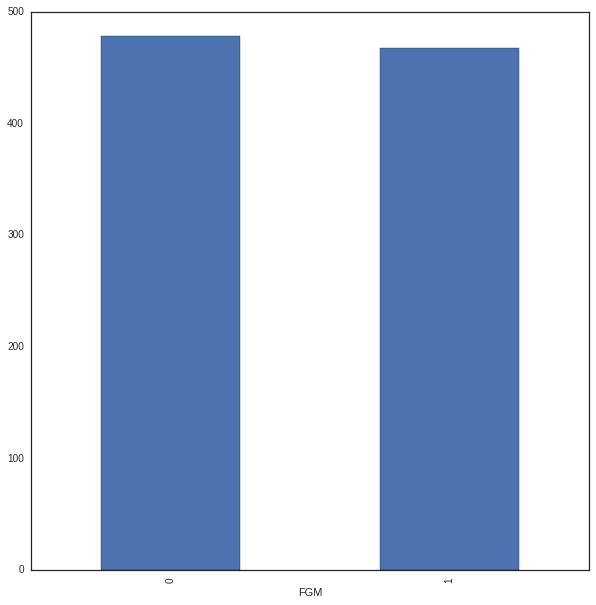

In [117]:
ax = lebrondf.groupby("FGM").size().plot(kind="bar", figsize=(10,10))

